# Лабораторная работа №6 (Проведение исследований с моделями классификации)

## Выбор начальных условий

### Обоснование выбора набора данных
Классификация изображений камней и ракушек имеет важное научно-практическое значение в различных областях. В геологии и морской биологии точное определение типов камней и ракушек помогает в научных исследованиях и экологическом мониторинге прибрежных зон. Для музеев и коллекционеров автоматизация классификации позволяет эффективнее каталогизировать экспонаты и образцы. В образовательных целях такие модели могут служить инструментом для обучения студентов основам геологии и морской биологии. Коммерческое применение включает контроль качества в декоративной промышленности и автоматизацию сортировки в добывающей отрасли. Также данная классификация важна в археологии для идентификации артефактов и в экологическом мониторинге для оценки состояния морских экосистем и пляжных зон.

### Выбор метрики
F1-Score: Для задачи классификации камней и ракушек F1-Score является оптимальной метрикой, так как обеспечивает баланс между точностью (precision) и полнотой (recall). Это особенно важно в случаях, когда в наборе данных может присутствовать дисбаланс классов или когда последствия неправильной классификации существенны (например, при научных исследованиях или сортировке ценных образцов). F1-Score позволяет одновременно минимизировать ложноположительные и ложноотрицательные результаты, что критично для обеспечения надежности классификации в практических приложениях, где требуется высокая точность распознавания обоих типов объектов.


## Подготовка данных

### Импорт библиотек
Импортируем основные библиотеки PyTorch и torchvision, которые будем использовать для обработки данных и создания модели.

In [3]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim
import kagglehub
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import math
import torchvision.transforms as T
from torchvision.models import vit_b_16
import random
import shutil

Загружаем датасет

In [20]:
path = kagglehub.dataset_download("vencerlanz09/shells-or-pebbles-an-image-classification-dataset")

100%|██████████| 195M/195M [00:18<00:00, 11.1MB/s] 

Extracting files...


In [21]:
def split_dataset(source_dir, dest_dir, train_ratio=0.7, valid_ratio=0.15, test_ratio=0.15):
    train_dir = os.path.join(dest_dir, 'train')
    valid_dir = os.path.join(dest_dir, 'valid')
    test_dir = os.path.join(dest_dir, 'test')

    os.makedirs(dest_dir, exist_ok=True)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_name in class_dirs:
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        class_path = os.path.join(source_dir, class_name)
        images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f)) and
                 (f.lower().endswith('.jpg') or f.lower().endswith('.jpeg') or
                  f.lower().endswith('.png') or f.lower().endswith('.bmp'))]

        random.shuffle(images)

        # Вычисляем границы разделения набора данных
        total_images = len(images)
        train_count = int(total_images * train_ratio)
        valid_count = int(total_images * valid_ratio)

        # Разделяем изображения
        train_images = images[:train_count]
        valid_images = images[train_count:train_count + valid_count]
        test_images = images[train_count + valid_count:]

        # Копируем файлы в новые директории
        for img in train_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in valid_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))

        for img in test_images:
            shutil.copy2(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

        print(f"Класс {class_name}: {len(train_images)} в обучающем, {len(valid_images)} в валидационном, "
              f"{len(test_images)} в тестовом наборе")
split_dataset(path, os.path.join(path, '..', 'done'))


Класс Pebbles: 1920 в обучающем, 411 в валидационном, 412 в тестовом наборе
Класс Shells: 1078 в обучающем, 231 в валидационном, 232 в тестовом наборе


In [25]:
path = os.path.join(path, '..', 'done')

Настройка путей и преобразований данных

In [26]:
train_dir = os.path.join(path, 'train')
valid_dir = os.path.join(path, 'valid')
test_dir = os.path.join(path, 'test')

# Преобразования для обучения и тестирования
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Загрузка данных и создание DataLoader

In [27]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


## CNN

### Обучение библиотечной модели

In [28]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        validation_preds = []
        validation_labels = []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                validation_preds.extend(preds.cpu().numpy())
                validation_labels.extend(labels.cpu().numpy())

        validation_f1 = f1_score(validation_labels, validation_preds, average='weighted')

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Validation F1-score: {validation_f1}")

    return model

Опишем функции для визуализации результатов

In [29]:
def imshow(ax, inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

def visualize_model(model, dataloader, num_images=6):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    images_so_far = 0

    cols = 3
    rows = math.ceil(num_images / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(12, rows * 4))
    axs = axs.flatten()
    fig.tight_layout()

    class_names = ['pebbles', 'shell']

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    return

                ax = axs[images_so_far]

                title = f'Pred: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}'
                imshow(ax, inputs.cpu().data[j], title)

                images_so_far += 1

    plt.show()

In [30]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_features, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 41.6MB/s]


In [31]:
# Параметры обучения
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [32]:
trained_model = train_model(resnet18, train_loader, valid_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.6244979716361837, Validation F1-score: 0.7425904635523007
Epoch 2/5, Loss: 0.5053853963283782, Validation F1-score: 0.5807411621766035
Epoch 3/5, Loss: 0.4999404853962837, Validation F1-score: 0.7755276032066409
Epoch 4/5, Loss: 0.5063848593767654, Validation F1-score: 0.7251350361244013
Epoch 5/5, Loss: 0.47197802491644597, Validation F1-score: 0.7662468685390903


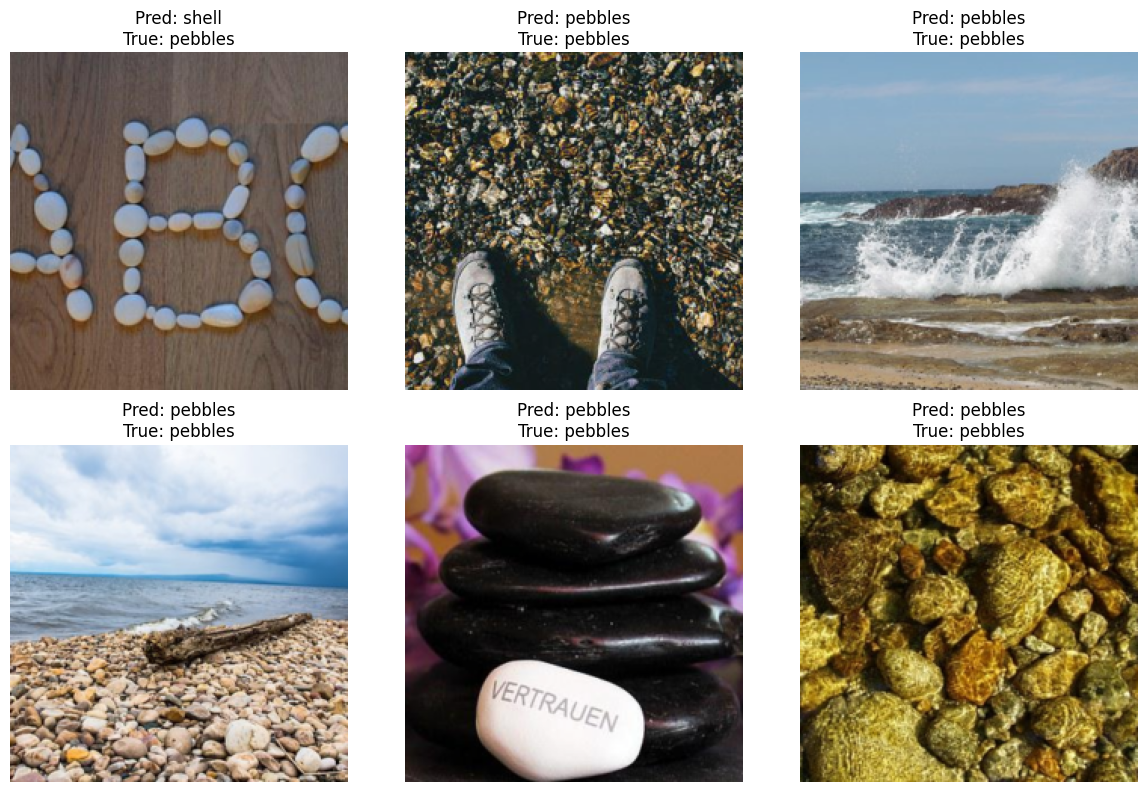

In [33]:
visualize_model(resnet18, test_loader, num_images=6)

В целом модель достаточно не плохо справляется с определение пола по изображению. Особенно если учесть особенность датасета, дело в том, что автор перепутал значения слов male и female, поэтому стоит учитывать что здесь female это мужчина

### Улучшенный бейзлайн CNN

Для улучшения показателей модели попробуем разнообразить данные. Предположим что применение преобразований к картинкам может попомьч выделить форму ракушек, с помошью цветов и форм. За одно применим базовые  преобразования для внесения разнообразности в данные

In [ ]:
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

class ColorJitterUneven(object):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue

    def __call__(self, img):
        r, g, b = TF.get_image_num_channels(img) == 3 and img.unbind(0) or (img, img, img)
        return TF.convert_image_dtype(torch.stack([r, g, b]), torch.float32)

class TextureEnhancement(object):
    def __init__(self, strength=0.2):
        self.strength = strength

    def __call__(self, img):
        return img


shell_rock_transforms = T.Compose([
    T.RandomResizedCrop(224, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    T.RandomRotation(15),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(p=0.2),
    T.ColorJitter(brightness=0.3, contrast=0.4, saturation=0.4, hue=0.1),
    T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
    T.ToTensor(),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.2),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

valid_transforms = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Применяем трансформации
train_impr_data = datasets.ImageFolder(train_dir, transform=shell_rock_transforms)
valid_impr_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

train_impr_loader = DataLoader(train_impr_data, batch_size=32, shuffle=True)
valid_impr_loader = DataLoader(valid_impr_data, batch_size=32, shuffle=False)


In [37]:
trained_model = train_model(resnet18, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.5266631667284255, Validation F1-score: 0.7788771625236209
Epoch 2/5, Loss: 0.45781744731233476, Validation F1-score: 0.7518661238347509
Epoch 3/5, Loss: 0.4547939642946771, Validation F1-score: 0.759113767962642
Epoch 4/5, Loss: 0.42135290769820516, Validation F1-score: 0.803571191981301
Epoch 5/5, Loss: 0.41895299801167024, Validation F1-score: 0.7401937150768926


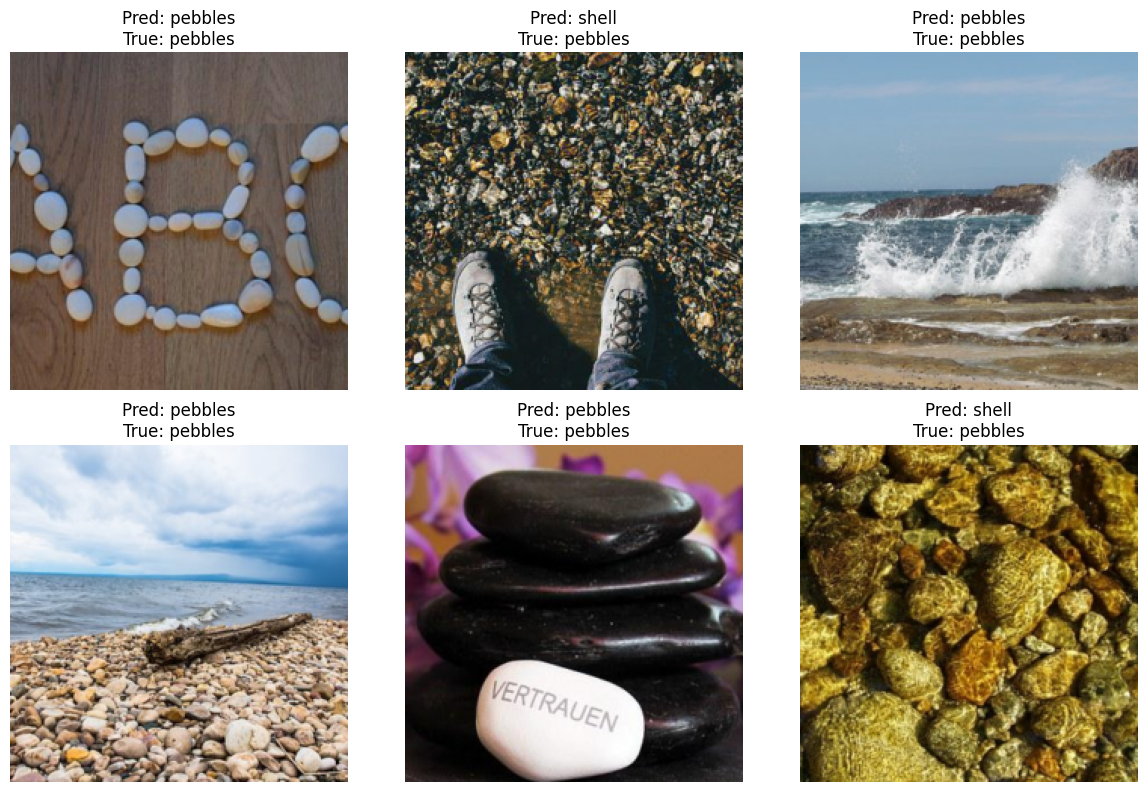

In [38]:
visualize_model(resnet18, test_loader, num_images=6)

Судя по метрикам гипотеза подтвердилась, по метрике f1-score точность увеличилась, видно как модель справилась с картинкой, с которой не справилась при первом обучении

### Собственная имплементация

Напишем свою реализацию модели

In [39]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 28 * 28, num_classes)
    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [40]:
custom_cnn = SimpleCNN()
custom_optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=1e-4)

In [41]:
trained_custom_cnn = train_model(custom_cnn, train_loader, valid_loader, criterion, custom_optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.7323075621686084, Validation F1-score: 0.6738631497806115
Epoch 2/5, Loss: 0.7047476175617664, Validation F1-score: 0.6681827198168988
Epoch 3/5, Loss: 0.8213254489163135, Validation F1-score: 0.627290558180868
Epoch 4/5, Loss: 0.6659899911981948, Validation F1-score: 0.6908046385463678
Epoch 5/5, Loss: 0.6900854094865474, Validation F1-score: 0.6499474499368216


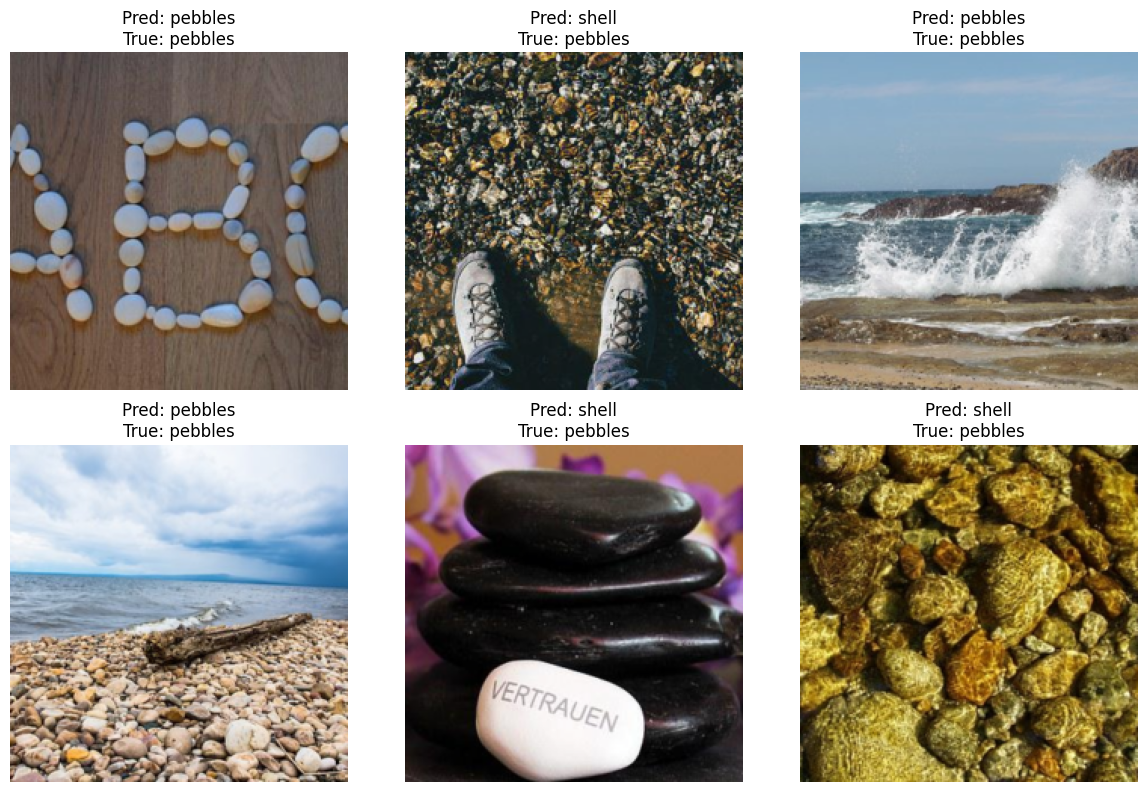

In [42]:
visualize_model(trained_custom_cnn, test_loader, num_images=6)

точность модели получилась хуже библиотечного варианта, попробуем применить тот же подход с аугментацией данных для улучшения качества предсказаний

### Улучшенный бейзлайн собственной имплементаци

In [43]:
trained_impr_custom_cnn = train_model(custom_cnn, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5, Loss: 0.6617658097059169, Validation F1-score: 0.6754331049802295
Epoch 2/5, Loss: 0.6635387067465072, Validation F1-score: 0.6803908563726967
Epoch 3/5, Loss: 0.6553356891616862, Validation F1-score: 0.6804690204222913
Epoch 4/5, Loss: 0.6635832780219139, Validation F1-score: 0.681766117565981
Epoch 5/5, Loss: 0.656654417831847, Validation F1-score: 0.6850279437795421


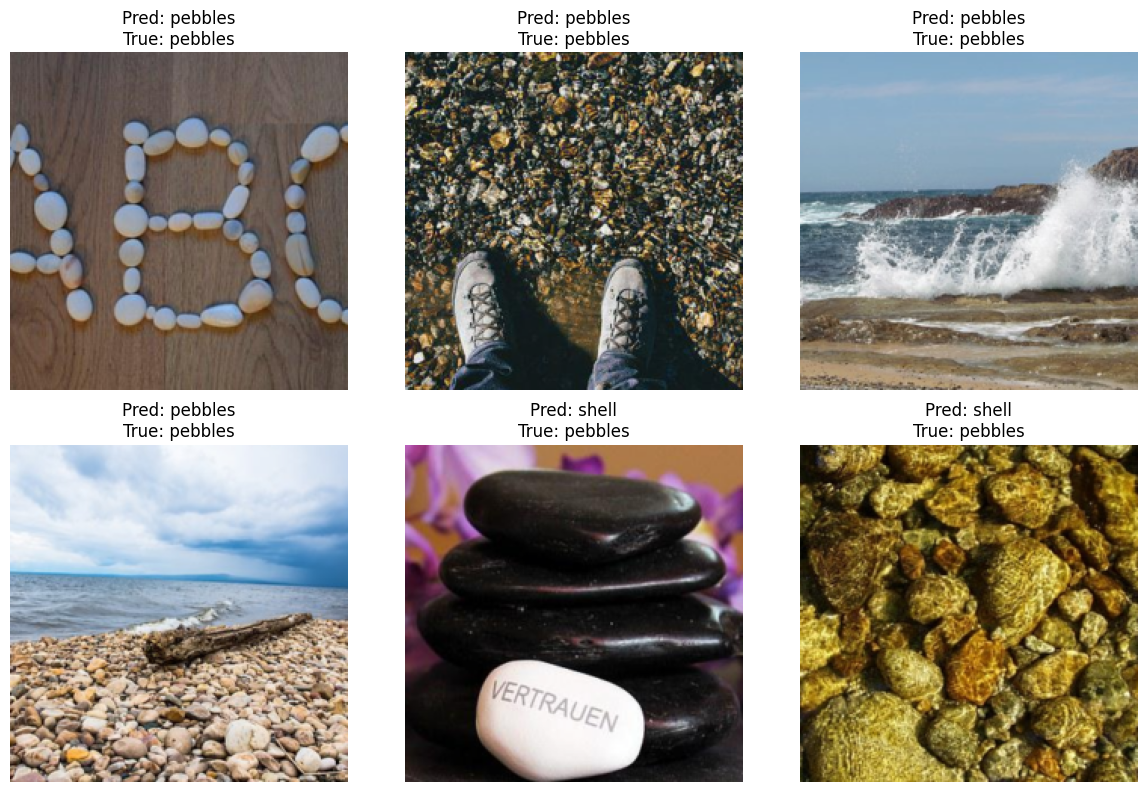

In [44]:
visualize_model(trained_impr_custom_cnn, test_loader, num_images=6)

Хоть и метрики незначительно улучшись относительно обычного бейзлайна свой модели, но всё равно не приблизились к простому бейзлайну библиотечной модели. Таким образом не получилось превзойти стандарную модель даже с учулчшенным бейзлайном

## Трансформер

### Vit_b_16

In [45]:
vit = vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /tmp/xdg_cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 53.8MB/s] 


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters(), lr=0.001)

In [47]:
trained_vit = train_model(vit, train_loader, valid_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.7130269186293825, Validation F1-score: 0.5639944207880944
Epoch 2/2, Loss: 0.6483412064770435, Validation F1-score: 0.5511982530314488


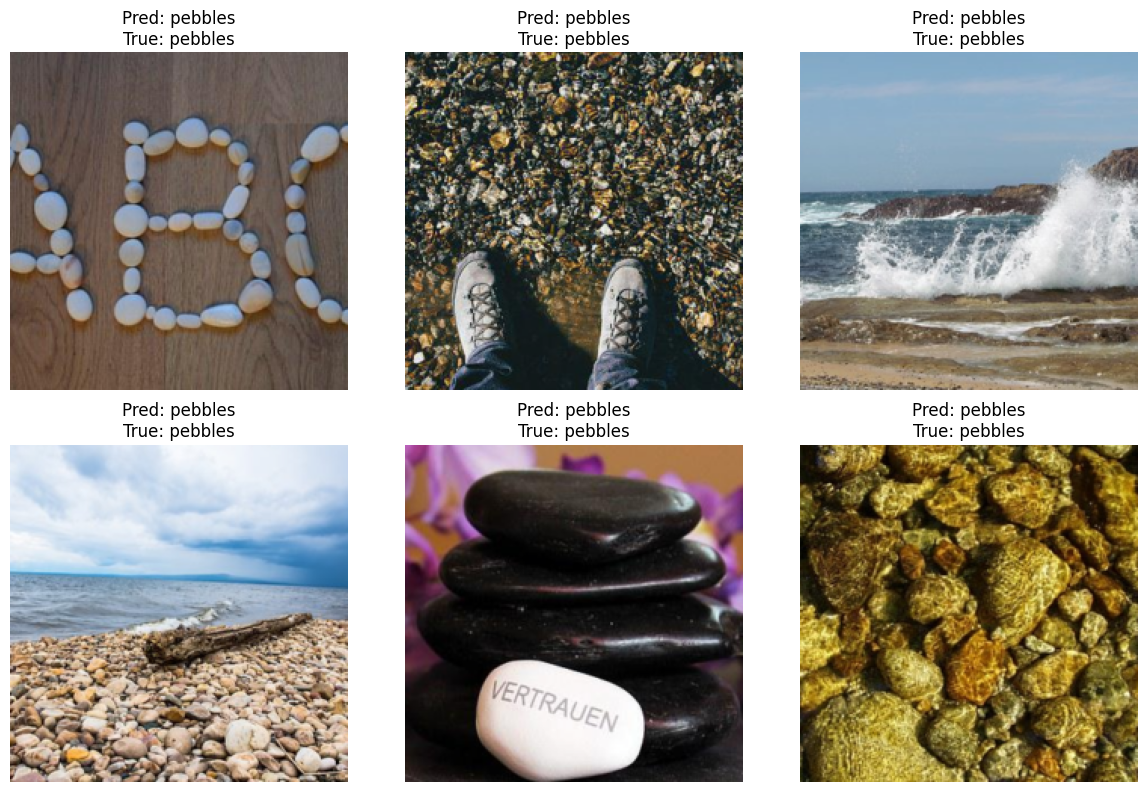

In [49]:
visualize_model(vit, test_loader, num_images=6)

Выглядит что модель не успела дообучиться за 2 эпохи, так как точность ещё достаточно плохая, но продолжает увеличиваться

### Улучшенный бейзлайн vit_b_16

Для улучшения, попробуем использовать трансформацию данных и за одно увеличить время обучения

In [51]:
trained_vit = train_model(vit, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=4)

Epoch 1/4, Loss: 0.633826732001406, Validation F1-score: 0.5480591292066791
Epoch 2/4, Loss: 0.6273573611644988, Validation F1-score: 0.6886488242569282
Epoch 3/4, Loss: 0.6255957515949898, Validation F1-score: 0.6704668997021241
Epoch 4/4, Loss: 0.6197201898123356, Validation F1-score: 0.6204377103797489


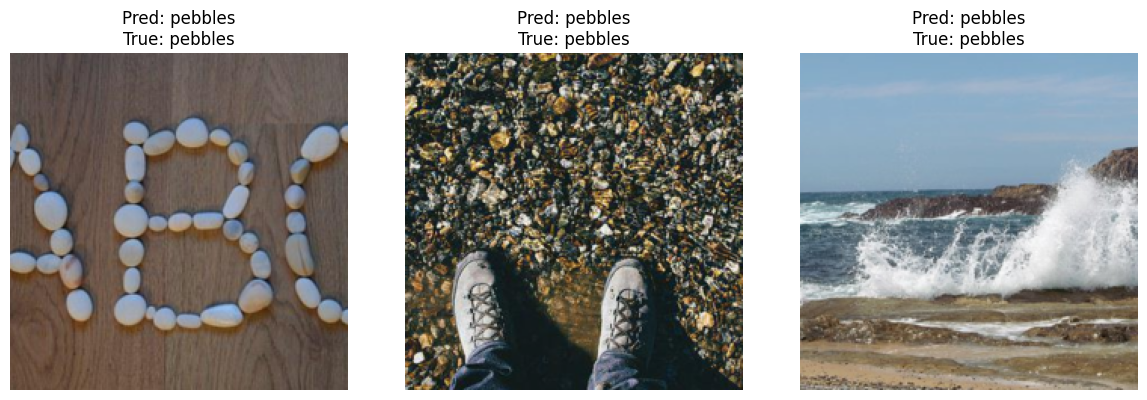

In [52]:
visualize_model(vit, test_loader, num_images=3)

Видно, что гипотеза подтверждается, и модель действительно начинает лучше справялться с задачей, что следует из увеличения метрик

### Собственная имплементация транформера

создадим свой аналог

In [53]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=224, patch_size=16, emb_dim=128, depth=6, n_heads=8, mlp_ratio=4, num_classes=2):
        super(SimpleViT, self).__init__()
        assert img_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(3, emb_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches+1, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads,
                                                   dim_feedforward=emb_dim * mlp_ratio, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Linear(emb_dim, num_classes)

        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1,2)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = x + self.pos_embed

        x = self.transformer(x)

        cls_out = x[:,0]
        return self.head(cls_out)

In [54]:
vit_base = SimpleViT()

In [55]:
vit_base_trained = train_model(vit, train_loader, valid_loader, criterion, optimizer, num_epochs=2)

Epoch 1/2, Loss: 0.6061646202777294, Validation F1-score: 0.5730023920402151
Epoch 2/2, Loss: 0.6078386756967991, Validation F1-score: 0.6862886855804895


Модель показала себя неожиданно хорошо, попробуем добиться точности CNN, при помощи улучшеного бейзлайна, который уже применяли ранее

### Улучшенный бейзлайн

In [56]:
vit_impr_trained = train_model(vit, train_impr_loader, valid_impr_loader, criterion, optimizer, num_epochs=4)

Epoch 1/4, Loss: 0.6050109733292397, Validation F1-score: 0.6838672784934466
Epoch 2/4, Loss: 0.6104722723681876, Validation F1-score: 0.6048920270447437
Epoch 3/4, Loss: 0.6025976221612159, Validation F1-score: 0.5549474799622964
Epoch 4/4, Loss: 0.5979620608243537, Validation F1-score: 0.6339817596554772


Неодназначные результаты, сначала модель показывала большое значение метрики, но затем обучение шло не стабильно, в итоге улучшенный бейзлайн стал работать хуже изначального

## Сводная таблица результатов

<table>
  <thead>
    <tr>
      <th>Архитектура</th>
      <th>Модификация</th>
      <th>Улучшенная</th>
      <th>F1-score</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>CNN</td>
      <td>Стандартная</td>
      <td>Нет</td>
      <td>0.7662468685390903</td>
    </tr>
    <tr>
      <td>CNN</td>
      <td>Стандартная</td>
      <td>Да</td>
      <td>0.803571191981301</td>
    </tr>
    <tr>
      <td>CNN</td>
      <td>Кастомная</td>
      <td>Нет</td>
      <td>0.6499474499368216</td>
    </tr>
    <tr>
      <td>CNN</td>
      <td>Кастомная</td>
      <td>Да</td>
      <td>0.6850279437795421</td>
    </tr>
    <tr>
      <td>Vision Transformer</td>
      <td>Стандартная</td>
      <td>Нет</td>
      <td>0.5511982530314488</td>
    </tr>
    <tr>
      <td>Vision Transformer</td>
      <td>Стандартная</td>
      <td>Да</td>
      <td>0.6204377103797489</td>
    </tr>
    <tr>
      <td>Vision Transformer</td>
      <td>Кастомная</td>
      <td>Нет</td>
      <td>0.6862886855804895</td>
    </tr>
    <tr>
      <td>Vision Transformer</td>
      <td>Кастомная</td>
      <td>Да</td>
      <td>0.6339817596554772</td>
    </tr>
  </tbody>
</table>


# Заключение

В ходе лабораторной работы были протестированы модели для классификации камней и ракушек. Анализируя F1-score, можно сделать следующие выводы:

   - Стандартная архитектура CNN, особенно с улучшениями, показала наилучшие результаты с F1-score до 0.803. Это подтверждает, что CNN хорошо подходит для задачи классификации на данном наборе данных.

   - Кастомные модификации CNN показали более низкие результаты по сравнению со стандартной версией, что указывает на необходимость оптимизации кастомных настроек.

   - Модели Vision Transformer, как стандартные, так и кастомные, продемонстрировали более низкие F1-score. Это может свидетельствовать о необходимости более детальной настройки для улучшения их производительности.

Для улучшения точности моделей можно предпринять следующие действия:
   - Рассмотреть увеличение объема обучающего набора данных.
   - Применить методы балансировки классов, чтобы избежать предвзятости моделей.
   - Оптимизировать гиперпараметры и архитектуру моделей, особенно для Vision Transformer, чтобы повысить их эффективность.